In [27]:
from sklearn.externals import joblib
from ctapipe.utils import get_dataset_path
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
import reco.calib_dl0_to_dl1 as calib
import reco.reco_dl1_to_dl2 as reco
import reco.plot_dl2 as lstplot
import numpy as np
import pandas as pd

In [2]:
#Import a simtelarray file with data
#datafile = get_dataset_path('gamma_test_large.simtel.gz')
datafile = "/scratch/bernardos/LST1/Gamma/Point_Prod-3_LaPalma_flashcam-prod3j/gamma_20deg_0deg_run11716___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"

In [3]:
#Select LST1 events from the file, calibrate them, extract hillas and timing parameters.
#DL0 -> DL1 
calib.max_events=1000
calib.r0_to_dl1(datafile)


0


/afs/ciemat.es/user/b/bernardos/GitHub/ctapipe/ctapipe/image/hillas.py:563: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)


100
200
300
400
500
600
700
800
900


In [31]:
#Take a look at the parameters extracted from the simtelarray file:
#data = pd.read_hdf('dl1_gamma_test_large.h5', key='events/LSTCam')
data = pd.read_hdf('dl1_gamma_20deg_0deg_run11716___cta-prod3-lapalma-2147m-LaPalma-FlashCam.h5', key='events/LSTCam')
data = data.dropna() #Take care of width nan values
print(data.keys())

Index(['disp', 'event_id', 'gps_time', 'hadroness', 'impact', 'intensity',
       'intercept', 'kurtosis', 'length', 'mc_alt', 'mc_alt_tel', 'mc_az',
       'mc_az_tel', 'mc_core_distance', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'obs_id', 'phi', 'psi', 'r',
       'skewness', 'src_x', 'src_y', 'time_gradient', 'width', 'wl', 'x', 'y'],
      dtype='object')


Text(0.5,0,'$log_{10} mc_energy$ (MeV)')

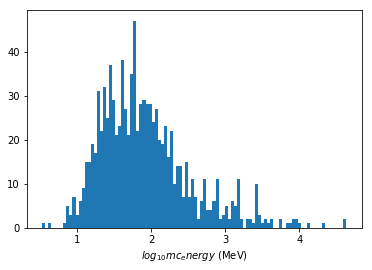

In [32]:
#We can plot some distributions:
plt.hist(data['mc_energy'],bins=100) #Log10(Energy) in MeV
plt.xlabel('$log_{10} mc_energy$ (MeV)')

Text(0.5,0,'$log_{10} intensity$')

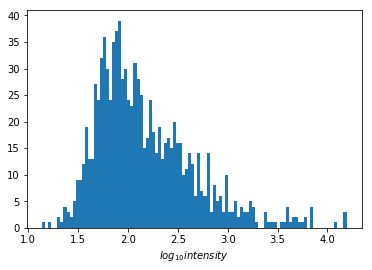

In [33]:
plt.hist(data['intensity'],bins=100) #Log10(intensity(size))
plt.xlabel('$log_{10} intensity$')

Text(0.5,0,'width (º)')

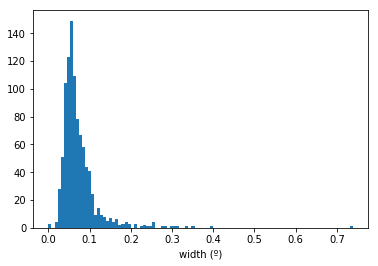

In [34]:
plt.hist(data['width'],bins=100) #Width in deg. Take care of nan width values
plt.xlabel('width (º)')

Text(0.5,0,'length (º)')

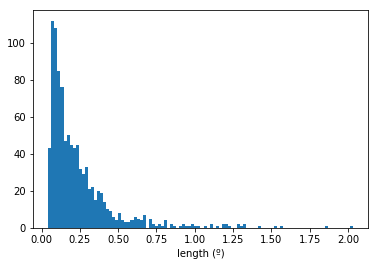

In [35]:
plt.hist(data['length'],bins=100) #Length in deg. 
plt.xlabel('length (º)')

Text(0,0.5,'y (m)')

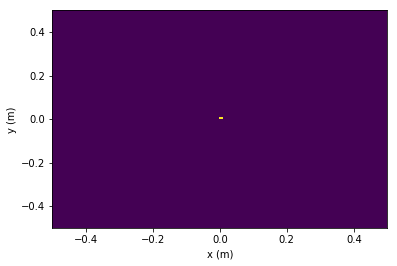

In [36]:
#See the source position: Point gammas or diffuse gammas? (camera coordinates)
plt.hist2d(data['src_x'],data['src_y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

Text(0,0.5,'y (m)')

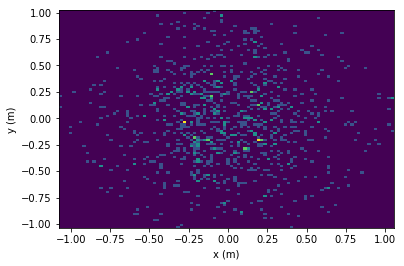

In [37]:
#Position of the hillas ellipse center of gravity (camera coordinates)
plt.hist2d(data['x'],data['y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

In [38]:
#Define the features to apply the RF:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                        
            'phi',                                                                                        
            'psi']
print(features)

['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi']


In [39]:
from sklearn.externals import joblib
#Load the three Random Forests:
#- Two Random Forests Regressors for Energy and disp_(source position) reconstruction
#- One Random Forest Classifier for gamma/hadron separation (uses results from previous RF as new features, e_rec, disp_rec)
path_models = "/scratch/bernardos/LST1/Models/"
                                                                  
fileE = path_models+"RFreg_Energy.sav"                                                               
fileD = path_models+"RFreg_Disp.sav"                                                                 
fileH = path_models+"RFcls_GH.sav"                                                                   
                                                                                                              
RFreg_Energy = joblib.load(fileE)                                                                         
RFreg_Disp = joblib.load(fileD)                                                                           
RFcls_GH = joblib.load(fileH)

In [40]:
#Now we have the trained RF that we can use them to reconstruct our data into dl2 format:
data_dl2 = data
reco.ApplyModels(data,data_dl2,features,RFcls_GH,RFreg_Energy,RFreg_Disp)
print(data_dl2.keys())

Index(['disp', 'event_id', 'gps_time', 'hadroness', 'impact', 'intensity',
       'intercept', 'kurtosis', 'length', 'mc_alt', 'mc_alt_tel', 'mc_az',
       'mc_az_tel', 'mc_core_distance', 'mc_core_x', 'mc_core_y', 'mc_energy',
       'mc_h_first_int', 'mc_type', 'mc_x_max', 'obs_id', 'phi', 'psi', 'r',
       'skewness', 'src_x', 'src_y', 'time_gradient', 'width', 'wl', 'x', 'y',
       'e_rec', 'disp_rec', 'src_x_rec', 'src_y_rec', 'hadro_rec'],
      dtype='object')


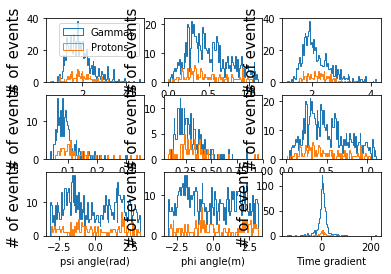

In [41]:
#Lets take a look to the results
lstplot.plot_features(data_dl2)

0.057984182710230175 0.6013460963878577


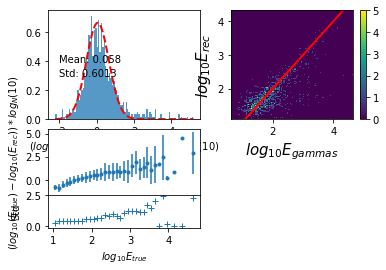

In [42]:
lstplot.plot_e(data_dl2)

0.0743144692404929 0.24352532363473137


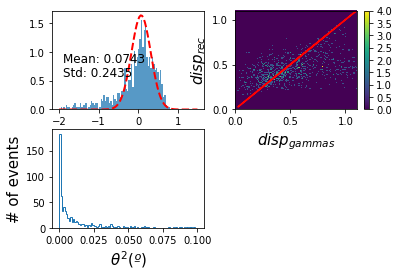

In [43]:
lstplot.plot_disp(data_dl2)

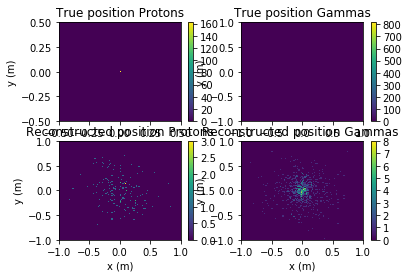

In [44]:
lstplot.plot_pos(data_dl2)

Text(0.5,0,'Hadroness')

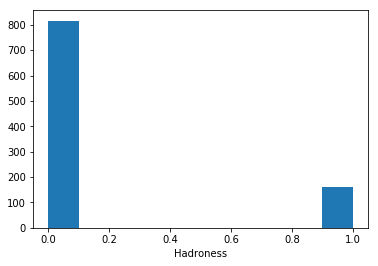

In [45]:
plt.hist(data_dl2['hadro_rec'])
plt.xlabel('Hadroness')

In [46]:
#We can apply a cut in energy and see the results again:
data_dl2 = data_dl2[data_dl2['e_rec']>2.699]

0.204781059941295 0.4119777333105566


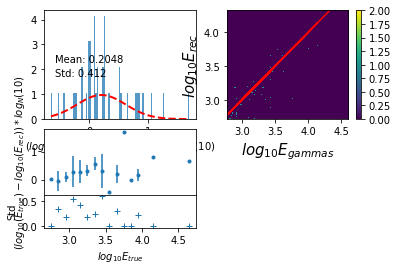

In [47]:
lstplot.plot_e(data_dl2)

0.06335144625587111 0.13662429816173022


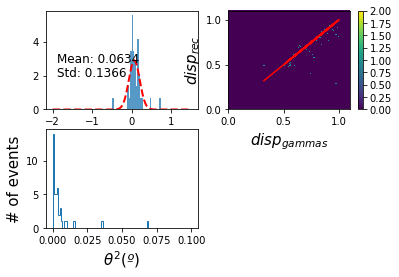

In [64]:
lstplot.plot_disp(data_dl2)

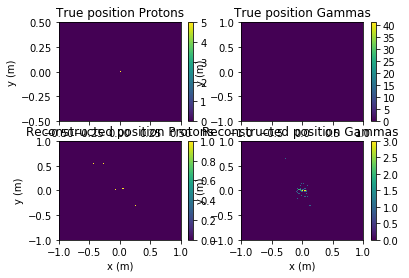

In [65]:
lstplot.plot_pos(data_dl2)

Text(0.5,0,'Hadroness')

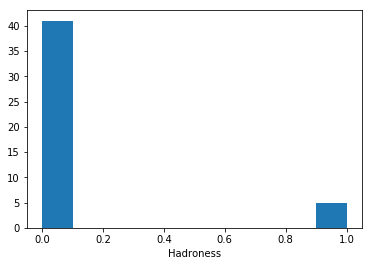

In [66]:
plt.hist(data_dl2['hadro_rec'])
plt.xlabel('Hadroness')